<b> Построение модели прогнозирования оттока клиентов и сегментация клиентов сети фитнес-центров «Культурист-датасаентист» </b>

<b> Оглавление проекта:</b>

[1. Загрузка и изучение данных.](#step_1)

[2. Исследовательский анализ данных (EDA).](#step_2)

[3. Построение модели прогнозирования оттока клиентов.](#step_3)

[4. Кластеризация клиентов сети.](#step_4)

[5. Вывод и базовые рекомендации по работе с клиентами.](#step_5)

<a id="step_1"></a> 
## Загрузка и изучение данных.

In [1]:
# загрузка библиотек
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.preprocessing import StandardScaler
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import KMeans

In [2]:
# загрузка данных
df_gym = pd.read_csv('/datasets/gym_churn.csv')
# выведем размер и первые 5 строк датасета
print(df_gym.shape)
df_gym.head()

(4000, 14)


,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
0,1,1,1,1,0,6,1,29,14.227470,5.0,3,0.020398,0.000000,0
1,0,1,0,0,1,12,1,31,113.202938,12.0,7,1.922936,1.910244,0
2,0,1,1,0,1,1,0,28,129.448479,1.0,2,1.859098,1.736502,0
3,0,1,1,1,1,12,1,33,62.669863,12.0,2,3.205633,3.357215,0
4,1,1,1,1,1,1,0,26,198.362265,1.0,3,1.113884,1.120078,0


In [3]:
df_gym.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   gender                             4000 non-null   int64  
 1   Near_Location                      4000 non-null   int64  
 2   Partner                            4000 non-null   int64  
 3   Promo_friends                      4000 non-null   int64  
 4   Phone                              4000 non-null   int64  
 5   Contract_period                    4000 non-null   int64  
 6   Group_visits                       4000 non-null   int64  
 7   Age                                4000 non-null   int64  
 8   Avg_additional_charges_total       4000 non-null   float64
 9   Month_to_end_contract              4000 non-null   float64
 10  Lifetime                           4000 non-null   int64  
 11  Avg_class_frequency_total          4000 non-null   float

In [4]:
# проверим датасет на наличие дубликатов
df_gym.duplicated().sum()

0

В данных 4000 наблюдений по 13 признакам и одно значение целевой переменной в столбце `Churn` — факт оттока в текущем месяце.

Пропусков в данных нет, все признаки численные.

<a id="step_2"></a> 
## Исследовательский анализ данных (EDA).

In [5]:
# изучим средние значения и стандартные отклонения признаков
df_gym.describe()

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
count,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000
mean,0.510250,0.845250,0.486750,0.308500,0.903500,4.681250,0.412250,29.184250,146.943728,4.322750,3.724750,1.879020,1.767052,0.265250
std,0.499957,0.361711,0.499887,0.461932,0.295313,4.549706,0.492301,3.258367,96.355602,4.191297,3.749267,0.972245,1.052906,0.441521
min,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,18.000000,0.148205,1.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,27.000000,68.868830,1.000000,1.000000,1.180875,0.963003,0.000000
50%,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,29.000000,136.220159,1.000000,3.000000,1.832768,1.719574,0.000000
75%,1.000000,1.000000,1.000000,1.000000,1.000000,6.000000,1.000000,31.000000,210.949625,6.000000,5.000000,2.536078,2.510336,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,12.000000,1.000000,41.000000,552.590740,12.000000,31.000000,6.023668,6.146783,1.000000


Изучим средние значения признаков в двух группах — тех, кто ушел в отток и тех, кто остался:

In [6]:
df_gym.groupby('Churn').mean().T

Churn,0,1
gender,0.510037,0.510839
Near_Location,0.873086,0.768143
Partner,0.534195,0.355325
Promo_friends,0.353522,0.183789
Phone,0.903709,0.902922
Contract_period,5.747193,1.728558
Group_visits,0.464103,0.268615
Age,29.976523,26.989632
Avg_additional_charges_total,158.445715,115.082899
Month_to_end_contract,5.283089,1.662582


 Разделим столбцы на две категории числовые и булевые.

In [7]:
numeric_columns = df_gym[['Age','Avg_additional_charges_total',
                         'Lifetime','Avg_class_frequency_total']]
boolean_columns = df_gym[['Contract_period','gender','Near_Location','Partner','Promo_friends','Phone',
                         'Group_visits','Churn']]

Построим диаграммы размаха распределения числовых признаков для тех, кто ушёл (отток) и тех, кто остался:

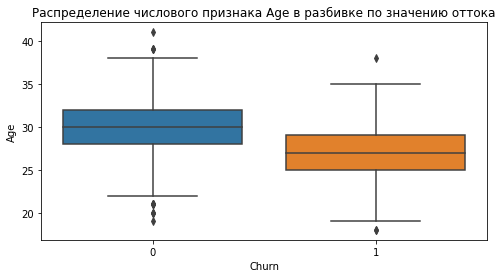

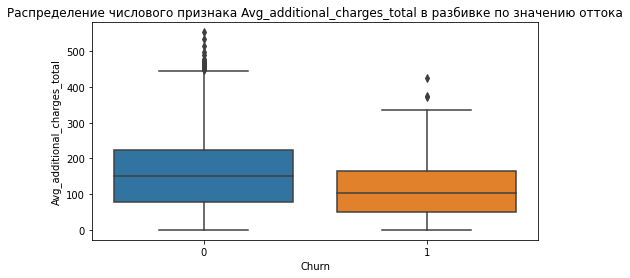

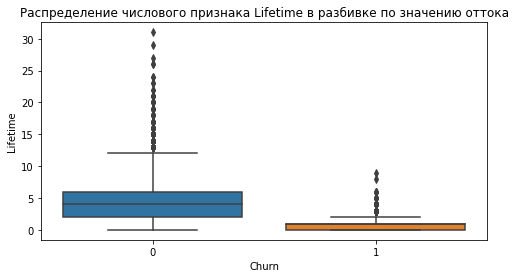

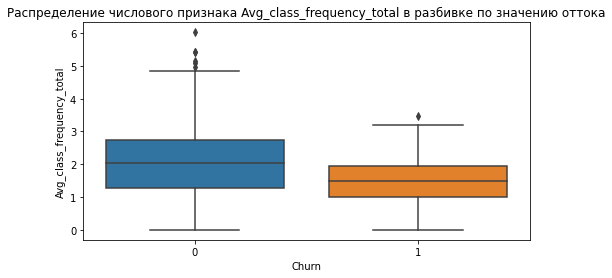

In [8]:
for column in numeric_columns:
    plt.figure(figsize=(8, 4))
    sns.boxplot(x=df_gym['Churn'],y=df_gym[column])
    plt.title(f'Распределение числового признака {column} в разбивке по значению оттока')
    plt.show()

Медианные значения и верхние границы всех числовых признаков меньше для ушедших клиентов относительно значений оставшихся клиентов.

Особенно стоит отметить признаки `Lifetime` и `Avg_class_frequency_total`, различия в распределениях для данных признаков по двум группам наиболее заметны.

Построим countplot распределения булевых признаков для тех, кто ушёл (отток) и тех, кто остался:

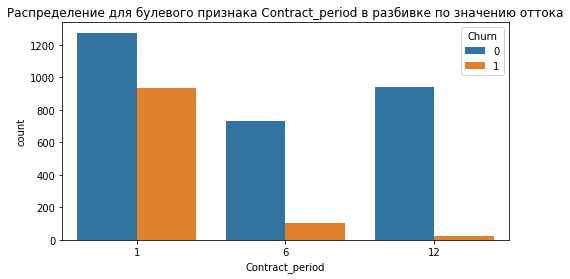

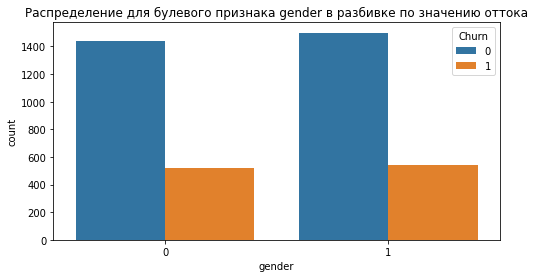

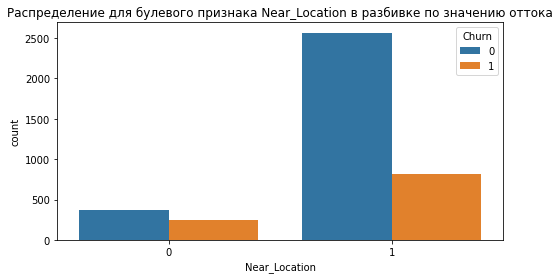

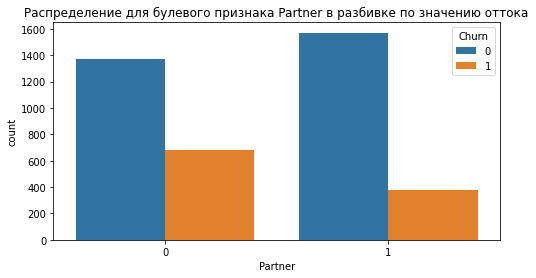

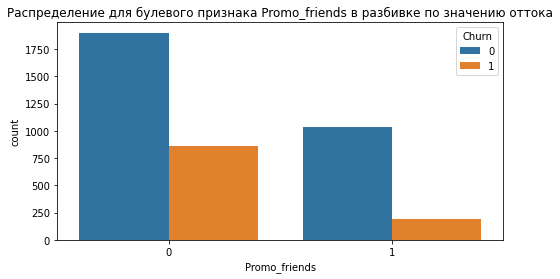

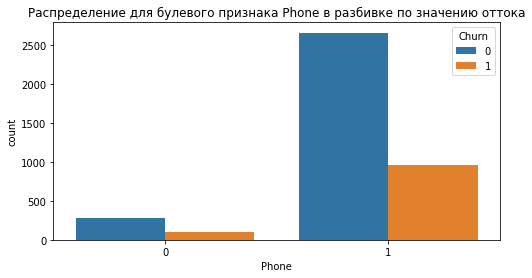

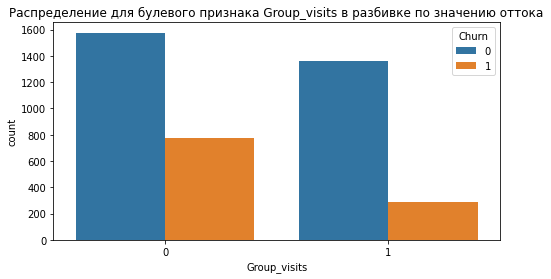

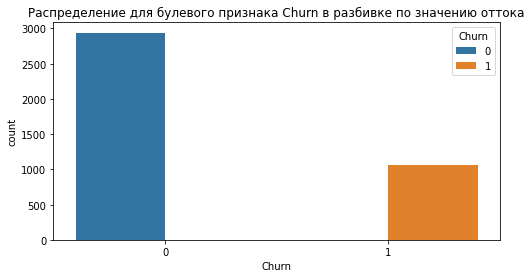

In [9]:
for column in boolean_columns:
    plt.figure(figsize=(8, 4))
    sns.countplot(x=df_gym[column], hue='Churn', data=df_gym)
    plt.title(f'Распределение для булевого признака {column} в разбивке по значению оттока')
    plt.show()

Клиенты фитнес-центра с длительностью абонемента в один месяц, уходят в отток значительно чаще, чем клиенты с длительность абонемента в 6 или 12 месяцев.

Клиенты, не являющиеся сотрудником компании-партера уходят чаще, чем клиенты являющиеся таковыми.

Также стоит отметить, что клиенты не посещающие групповые занятия подвержены оттоку более тех, кто посещает групповые.

Построим матрицу корреляций.

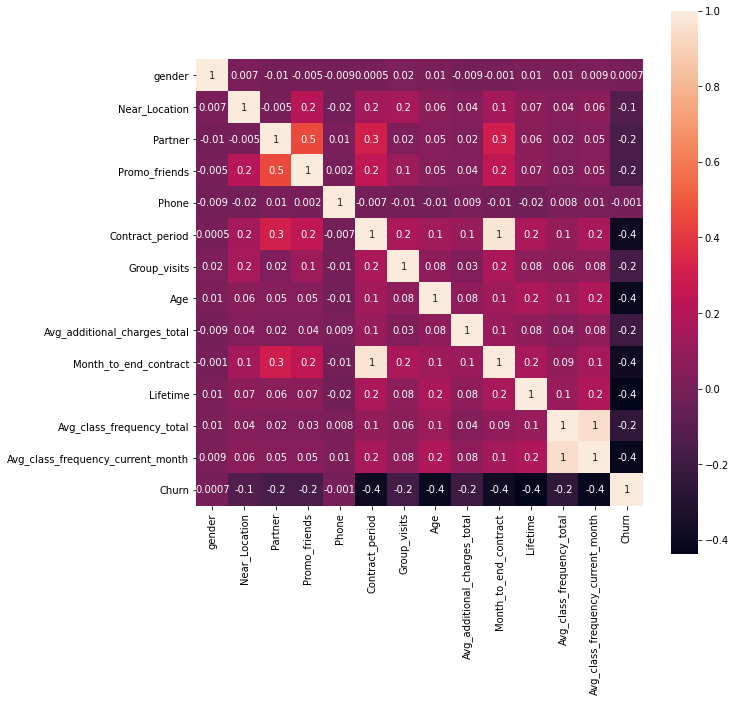

In [10]:
plt.figure(figsize=(10, 10))
cm = df_gym.corr()
sns.heatmap(cm, annot=True, square=True, fmt='.1g')
plt.show()

После построения матрицы корреляции, обнуружились две пары признаков значение корреляции которых ровно единице.

Первая пара признаков:
* Month_to_end_contract
* Contract_period

Вторая пара признаков:
* Avg_class_frequency_total
* Avg_class_frequency_current_month

Для линейных моделей мультиколлинеарность может привести к не корректным результатам.Следует удалить один любой признак в каждой паре. 

In [11]:
# удаляем один из мультиколлинеарных признаков
df_gym = df_gym.drop(['Month_to_end_contract','Avg_class_frequency_current_month'], axis = 1)

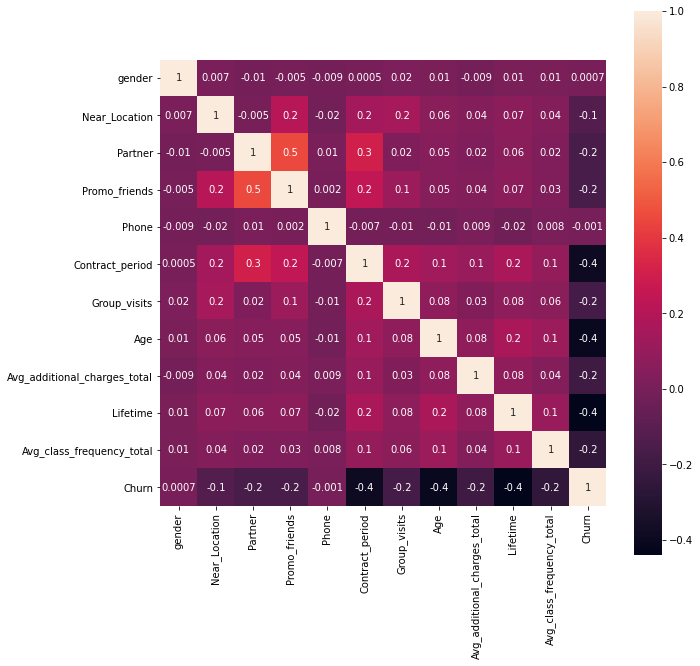

In [12]:
# построим матрицу корреляции после преобразований
plt.figure(figsize=(10, 10))
cm = df_gym.corr()
sns.heatmap(cm, annot=True, square=True, fmt='.1g')
plt.show()

<b> Выводы по результатам исследовательского анализа данных: </b>

Можно предположить, что важными признаками для моделирования оттока и кластеризации клиентов могут послужить: 
* длительность текущих абонементов, чем меньше длительность абонемента, тем выше отток в данной группе;
* количество месяцев с момента первого обращения в фитнес-центр и среднее количество посещений в неделю, чем ниже данные показатели, тем выше отток;
* посещение групповых занятий, оставшиеся более склонны к посещению групповых занятий;
* тот факт, является ли человек сотрудником компании-партнёра клуба, являющиеся таковыми менее подвержены оттоку.

Тем временем, гендер и наличие контактного телефона не влияет на отток клиентов.

<a id="step_3"></a> 
## Построение модели прогнозирования оттока клиентов.

Построим модель бинарной классификации клиентов, где целевой признак — факт оттока клиента в следующем месяце.

In [13]:
# разделим данные на признаки (матрица X) и целевую переменную (y)
X = df_gym.drop(columns=['Churn','gender','Phone'])
y = df_gym['Churn']

In [14]:
# разделяем модель на обучающую и валидационную выборку в отношении 80% к 20%.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2 ,random_state=0)

In [15]:
# стандартизируем данные
scaler = StandardScaler() 
#обучаем scaler и одновременно трансформируем матрицу для обучающей выборки
X_train_st = scaler.fit_transform(X_train)
# применяем стандартизацию к матрице признаков для тестовой выборки:
X_test_st = scaler.transform(X_test)

In [16]:
# задаем список моделей
models = [LogisticRegression(solver='liblinear',random_state = 0),
          RandomForestClassifier(random_state = 0)]

# функция, которая принимает на вход модель и данные и выводит метрики
def make_prediction(m, X_train, y_train, X_test, y_test):
    model = m
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print(
        'Accuracy:{:.2f} Precision :{:.2f} Recall :{:.2f} '.format(
            accuracy_score(y_test, y_pred),
            precision_score(y_test, y_pred),
            recall_score(y_test, y_pred)
        )
    )


# цикл, который выводит метрики по списку моделей
for i in models:
    print(i)
    make_prediction(
        i,
        X_train,
        y_train,
        X_test,
        y_test
    )

LogisticRegression(random_state=0, solver='liblinear')
Accuracy:0.88 Precision :0.75 Recall :0.78 
RandomForestClassifier(random_state=0)
Accuracy:0.89 Precision :0.78 Recall :0.77 


Доля правильных ответов на один процентный пункт выше у модели случайного леса, следовательно доля верно угаданных ответов из всех прогнозов выше.

Доля правильных ответов только среди целевого класса, метрика Precision, также лучше для модели случайного леса.

Метрика Recall отражает сколько реальных объектов "1" класса смогла обнаружить модель, значение данной метрики одинаково для обеих моделей. 

Модель случайный лес показала метрики лучше, чем модель логистической регрессии.

<a id="step_4"></a> 
## Кластеризация клиентов сети.

In [17]:
# стандартизируем данные
scaler = StandardScaler() 
X_sc = scaler.fit_transform(df_gym.drop(columns = ['Churn']))

### Построение матрицы расстояний на стандартизованной матрице признаков и  построение дендрограммы. 

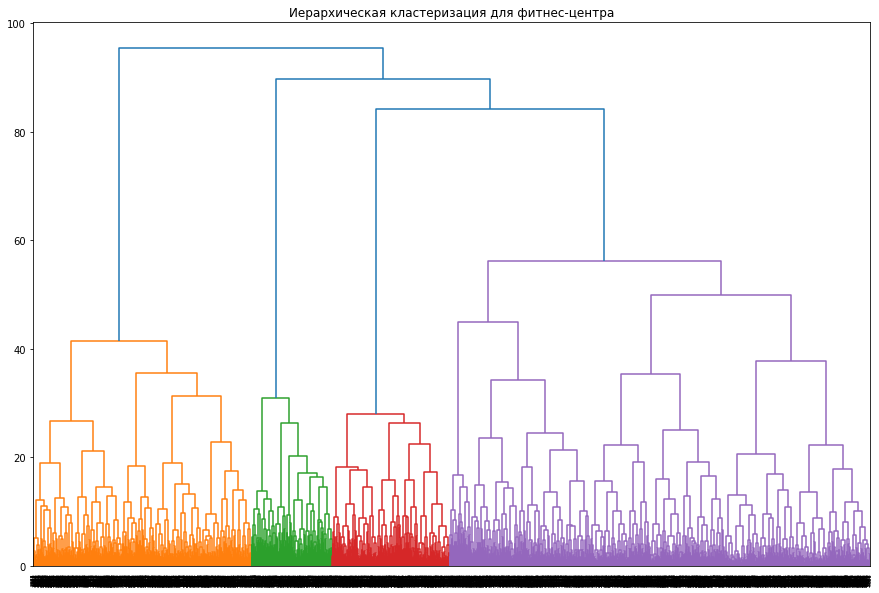

In [18]:
linked = linkage(X_sc, method = 'ward') 
plt.figure(figsize=(15, 10))  
dendrogram(linked, orientation='top')
plt.title('Иерархическая кластеризация для фитнес-центра')
plt.show() 

На основании полученного графика предположим, что можно выделить пять кластеров — пять разных цветов на графике.

### Обучение модели кластеризации на основании алгоритма K-Means.

In [19]:
# задаём модель k_means с числом кластеров 5
km = KMeans(n_clusters=5, random_state=0)

# прогнозируем кластеры для наблюдений
labels = km.fit_predict(X_sc)

# сохраняем метки кластера в поле датасета
df_gym['cluster_km'] = labels

df_gym.head()

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Lifetime,Avg_class_frequency_total,Churn,cluster_km
0,1,1,1,1,0,6,1,29,14.227470,3,0.020398,0,4
1,0,1,0,0,1,12,1,31,113.202938,7,1.922936,0,3
2,0,1,1,0,1,1,0,28,129.448479,2,1.859098,0,2
3,0,1,1,1,1,12,1,33,62.669863,2,3.205633,0,1
4,1,1,1,1,1,1,0,26,198.362265,3,1.113884,0,1


In [20]:
# выводим статистику по средним значениям признаков по кластеру
df_gym.groupby('cluster_km').mean()

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Lifetime,Avg_class_frequency_total,Churn
cluster_km,,,,,,,,,,,,
0,0.499109,0.000000,0.488414,0.076649,1.0,3.032086,0.235294,28.721925,137.540009,3.060606,1.770413,0.399287
1,0.488571,0.995238,0.955238,0.892381,1.0,7.660952,0.458095,29.543810,155.861428,4.380952,1.978963,0.120952
2,0.505300,1.000000,0.238516,0.059187,1.0,2.819788,0.000000,28.770318,143.383993,3.343640,1.800647,0.381625
3,0.544202,1.000000,0.250287,0.079219,1.0,4.528129,1.000000,29.536165,148.088897,3.761194,1.941342,0.200918
4,0.523316,0.862694,0.471503,0.305699,0.0,4.777202,0.427461,29.297927,144.208179,3.940415,1.854211,0.266839


Следует заметить,что нулевой кластер больше прочих подвержен оттоку. Можно предположить, что ключевым образом это связанно с значением параметра Near_Location равным 0. Также что значения следующих параметров для данного кластера также ниже, чем для других:
* время с момента первого обращения в фитнес-центр;
* средняя частота посещений в неделю за предыдущий месяц;
* суммарная выручка от других услуг фитнес-центра.

Также подвержен оттоку кластер под номером 2.

### Построение графиков распределения признаков для кластеров. 

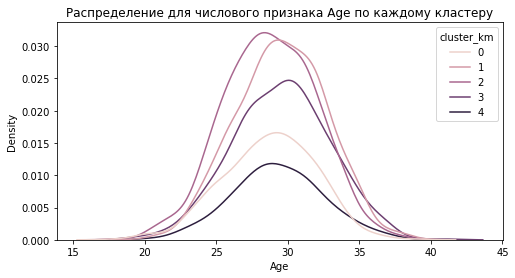

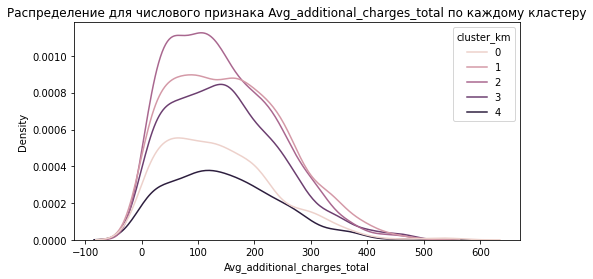

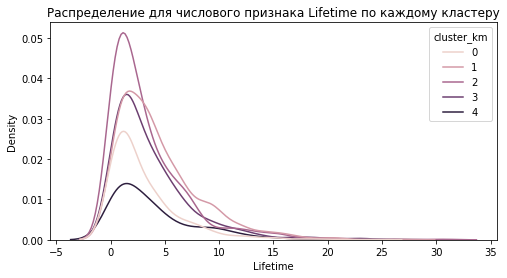

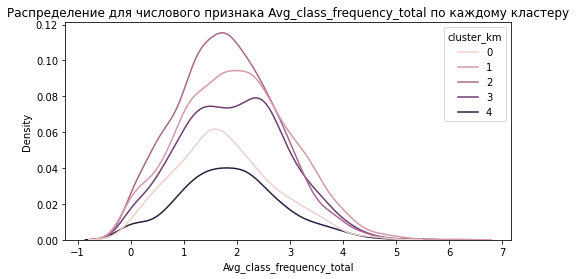

In [21]:
for column in numeric_columns:
    plt.figure(figsize=(8, 4))
    sns.kdeplot(x=df_gym[column], hue='cluster_km', data=df_gym)
    plt.title(f'Распределение для числового признака {column} по каждому кластеру')
    plt.show()

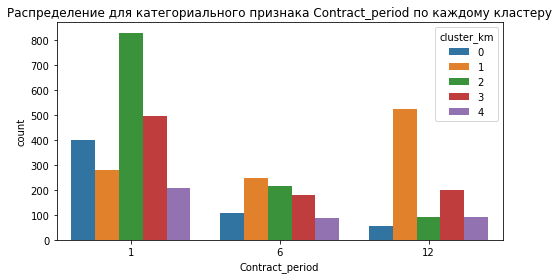

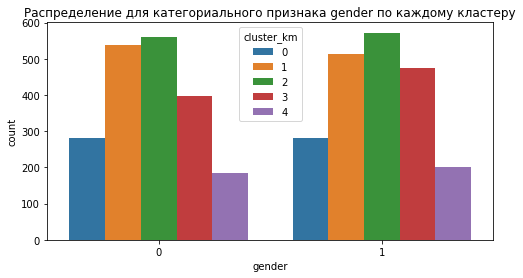

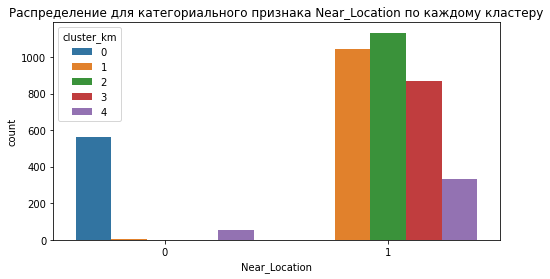

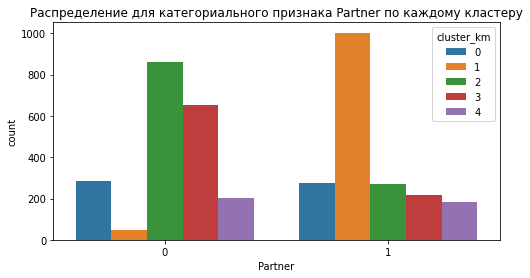

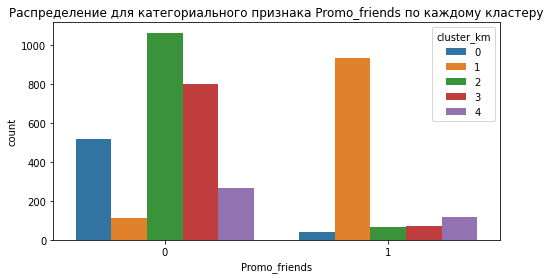

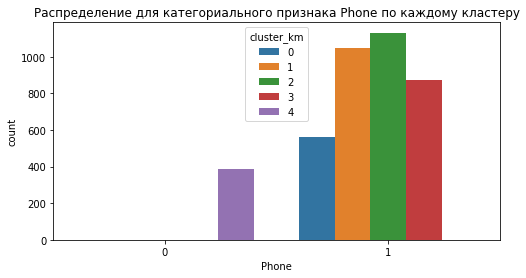

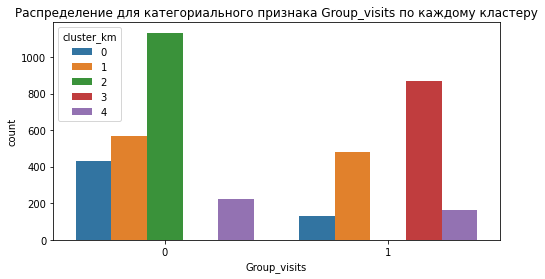

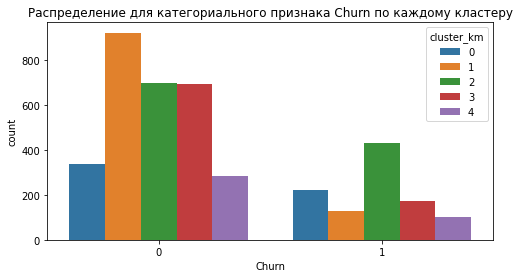

In [22]:
for column in boolean_columns:
    plt.figure(figsize=(8, 4))
    sns.countplot(x=df_gym[column], hue='cluster_km', data=df_gym)
    plt.title(f'Распределение для категориального признака {column} по каждому кластеру')
    plt.show()

Опишем приоритетные особенности для каждого кластера.

Кластер под номером 0:

Наиболее характерный для данного кластера признак нулевое значение параметра Near_Location посетители из данного кластера жувут и работают не в районе, где находится фитнес-центр и ожидаемо имеют низкие значения признака "Средняя частота посещений в неделю за все время с начала действия абонемента" и "Суммарная выручка от других услуг фитнес-центра". Данный кластер характеризует клиентов, редко посещающих центр.

Кластер под номером 1:

Для данного класстера характерными признаками являются:
Высокая длительность текущего абонемента, высокие показатели суммарной выручки от других услуг фитнес-центра, проживание в районе фитнес-центра, следовательно, это постоянные посетители фитнес-центра, стабильно приносящие дополнительный доход центру.

Кластер под номером 2:

Наиболее характерный для данного кластера признаки низкая длительность действующего абонемента и проживание или работа в районе, где находится фитнес-центр, клиентов данного кластера теоретически возможно сделать постоянными посетителями клуба.

Кластер под номером 3:

Отличительной чертой данного кластера является посещение групповых занятий и близкое проживание.

Кластер под номером 4:

Кластер без выраженного отличительного признака.

Изучим отток посетителей по кластерам.

In [23]:
df_gym_visitors = df_gym.groupby(['cluster_km','Churn']).agg({'gender':'count'})
df_gym_visitors = df_gym_visitors.reset_index()
df_gym_visitors = df_gym_visitors.rename(columns={'gender':'visitors'}).sort_values(by='visitors')
df_gym_visitors

,cluster_km,Churn,visitors
9,4,1,103
3,1,1,127
7,3,1,175
1,0,1,224
8,4,0,283
0,0,0,337
5,2,1,432
6,3,0,696
4,2,0,700
2,1,0,923


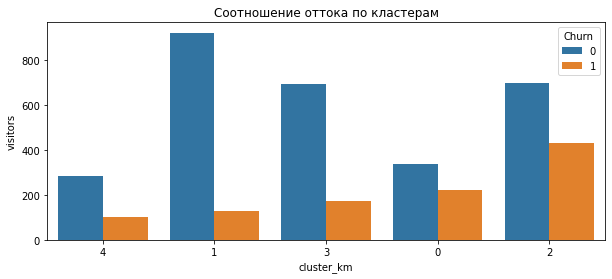

In [24]:
plt.figure(figsize=(10,4))
ax = sns.barplot(x='cluster_km',y='visitors',data=df_gym_visitors,hue='Churn',
                 order=df_gym_visitors.query('Churn == 1').sort_values(by='visitors').cluster_km)
plt.title('Соотношение оттока по кластерам')
plt.show()

Рассчитаем для каждего кластера долю оттока

In [25]:
df_gym.groupby('cluster_km')['Churn'].mean()

cluster_km
0    0.399287
1    0.120952
2    0.381625
3    0.200918
4    0.266839
Name: Churn, dtype: float64

<a id="step_5"></a> 
## Вывод и базовые рекомендации по работе с клиентами.

Для прогнозирования оттока посетитиелей фитнес-цетра следует использовать модель `RandomForestClassifier`, имеющая преимущество в значениях метриков перед моделью `LogisticRegression`.

Базовые рекомендации по работе с клиентами:
1. Наибольший отток имеют посетители кластера 0, для которого характерно проживание и работа в другом районе. Клиентов данного кластера потенциально могут удержать доступные цены на продление абонементов, таким клиентам можно предложить скидки или акции на продление.Стоит заметить, что клиенты данного кластера покупают абонементы, но посещают центр редко.


2. Кластер 1 - постоянные посетители,живущие рядом и покупающие дополнительные услуги центра, данным клиентам можно организовать рассылку с предложением или напоминанием посетить дополнительные услуги центра. Также для потенциального снижения оттока в данном кластере, возможно предложить посетителям купить абонемент сразу на 2 года вперед. 


3. Среди посетителей кластера 2 также большая доля оттока, однако признаками данного кластера являются низкая длительность действующего абонемента при признаке проживания или работы рядом с фитнес-центром. Потенциально, клиентов данного кластера возможно сделать постоянными клиентами, для этого следует предложить особые условия на продление абонемента на длительный срок.


4. Для потенциального увеличения прибыли, клиентам кластера 3 следует организовать рассылку с предложением посещения платных групповых занятий по новому или наиболее популярному для фитнес-центра направлению.
